# **Hyperparameter Tuning of Classification Models on the Loan Dataset**


---





**Importing appropriate libraries**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder

---


**Read dataset and explore it**




In [3]:
df = pd.read_csv('Loan_data.csv', sep=',', header=0)

In [ ]:
df.head()



---


**Data preprocessing:**


*   Select appropriate coulmns for df
* Define X, y as data and labeles
*   Drop Null data or fill them
*   Label Encoding "Gender", "Married", "Education", "Self_Employed", "Property_Area" Using:
> 1. Use pd.get_dummies(df) to one-hot-encoding
> 2. Use LabelEncoder()
* Plot pairplot to see divertion of data






In [5]:
selected_columns = [
    'Credit_History', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Loan_Amount_Term', 'Property_Area', 'Dependents', 'Loan_Status'
]
df = df[selected_columns]
y = df['Loan_Status']
X = df.drop('Loan_Status', axis=1)

In [6]:
'''
Since the overall missing rate is low (<10% per column) and data size is small,
filling is the better choice.
'''

for col in X.select_dtypes(include=['object']).columns:
  X[col] = X[col].fillna(X[col].mode()[0])

for col in X.select_dtypes(include=['int', 'float']).columns:
  X[col] = X[col].fillna(X[col].mean())

# X = X.dropna()

In [7]:
'''
Using LabelEncoder() can make models think one category (like 'Female')
is greater than another (like 'Male'), even if that’s not true.
'''

X = pd.get_dummies(X, dtype=float)
lbl_encoder = LabelEncoder()
y = lbl_encoder.fit_transform(y)


# lbls = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]
# for lbl in lbls:
#   X[lbl] = lbl_encoder.fit_transform(X[lbl])

In [ ]:
X.info()

In [ ]:
X.isna().sum()

In [10]:
# sns.pairplot(df)



---

**Spliting Dataset into train and test sets**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)



---

**Define Models and Parameters**

In [12]:
model_lbl = [
    'dt',
    'rf',
    'knn',
    'nb',
    'ln',
    'adb'
]


models = {
    'dt': {
        'name': 'Decision Tree Classification',
        'estimator': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'knn': {
        'name': 'K Nearest Neighbour',
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'manhattan']
        }
    },
    'nb': {
        'name': 'Naive Bayes',
        'estimator': GaussianNB(),
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07]
        }
    },
    'ln': {
        'name': 'Linear Classifier',
        'estimator': Perceptron(),
        'params': {
            'penalty': [None, 'l2', 'l1', 'elasticnet'],
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [1000, 5000]
        }
    },
    'adb': {
        'name': 'AdaBoostClassifier',
        'estimator': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.5, 1.0, 1.5]
        }
    }
}

In [29]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
results = pd.DataFrame(columns=['scoring',
                                'model',
                                'params',
                                'accuracy',
                                'f1_macro',
                                'recall_macro',
                                'precision'])
scores = ['accuracy', 'f1_macro', 'recall_macro', 'precision']
clfs = []



---

**Hyperparameter Tunning using GridSearch**

In [30]:
for score in scores:
  for i in model_lbl:
    clf = GridSearchCV(estimator=models[i]['estimator'], param_grid=models[i]['params'], scoring=score, cv=skf,)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_pred = clf.predict(X_test)
    cr = classification_report(y_true=y_test,y_pred=y_pred, output_dict=True, zero_division=1)
    results.loc[len(results)] = [score,
                                 models[i]['name'],
                                 clf.best_params_,
                                 cr['accuracy'],
                                 cr['weighted avg']['f1-score'],
                                 cr['weighted avg']['recall'],
                                 cr['weighted avg']['precision']
                                 ]



---

**Showing Results and Confusion Matrixs**

In [34]:
for score in scores:
  print(f'**results for scoring: {score}**')
  display(results[results['scoring']==score].sort_values(by=score, ascending=False).head(6))
  print('\n\n\n')

**results for scoring: accuracy**


,scoring,model,params,accuracy,f1_macro,recall_macro,precision
5,accuracy,AdaBoostClassifier,"{'learning_rate': 0.5, 'n_estimators': 200}",0.788618,0.761491,0.788618,0.825253
3,accuracy,Naive Bayes,{'var_smoothing': 1e-09},0.780488,0.754213,0.780488,0.807175
1,accuracy,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.772358,0.746990,0.772358,0.790645
0,accuracy,Decision Tree Classification,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.756098,0.720299,0.756098,0.787066
4,accuracy,Linear Classifier,"{'alpha': 0.001, 'max_iter': 1000, 'penalty': ...",0.650407,0.512636,0.650407,0.772622
2,accuracy,K Nearest Neighbour,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",0.577236,0.497371,0.577236,0.461766






**results for scoring: f1_macro**


,scoring,model,params,accuracy,f1_macro,recall_macro,precision
11,f1_macro,AdaBoostClassifier,"{'learning_rate': 0.5, 'n_estimators': 200}",0.788618,0.761491,0.788618,0.825253
9,f1_macro,Naive Bayes,{'var_smoothing': 1e-09},0.780488,0.754213,0.780488,0.807175
7,f1_macro,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.764228,0.739819,0.764228,0.775446
6,f1_macro,Decision Tree Classification,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.747967,0.721875,0.747967,0.753116
10,f1_macro,Linear Classifier,"{'alpha': 0.01, 'max_iter': 1000, 'penalty': '...",0.512195,0.523371,0.512195,0.561234
8,f1_macro,K Nearest Neighbour,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",0.577236,0.497371,0.577236,0.461766






**results for scoring: recall_macro**


,scoring,model,params,accuracy,f1_macro,recall_macro,precision
13,recall_macro,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.788618,0.768334,0.788618,0.804807
17,recall_macro,AdaBoostClassifier,"{'learning_rate': 1.0, 'n_estimators': 100}",0.788618,0.761491,0.788618,0.825253
15,recall_macro,Naive Bayes,{'var_smoothing': 1e-09},0.780488,0.754213,0.780488,0.807175
12,recall_macro,Decision Tree Classification,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.715447,0.708804,0.715447,0.707052
16,recall_macro,Linear Classifier,"{'alpha': 0.0001, 'max_iter': 1000, 'penalty':...",0.650407,0.512636,0.650407,0.772622
14,recall_macro,K Nearest Neighbour,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",0.577236,0.497371,0.577236,0.461766






**results for scoring: precision**


,scoring,model,params,accuracy,f1_macro,recall_macro,precision
21,precision,Naive Bayes,{'var_smoothing': 1e-09},0.780488,0.754213,0.780488,0.807175
23,precision,AdaBoostClassifier,"{'learning_rate': 1.5, 'n_estimators': 50}",0.780488,0.757762,0.780488,0.797776
22,precision,Linear Classifier,"{'alpha': 0.0001, 'max_iter': 1000, 'penalty':...",0.650407,0.512636,0.650407,0.772622
19,precision,Random Forest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.739837,0.718558,0.739837,0.736194
18,precision,Decision Tree Classification,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.682927,0.677945,0.682927,0.675262
20,precision,K Nearest Neighbour,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",0.577236,0.497371,0.577236,0.461766


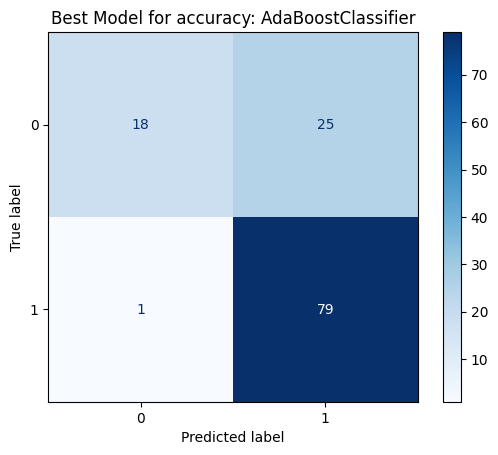

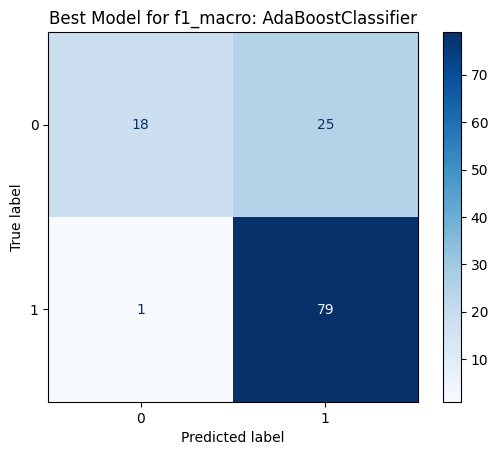

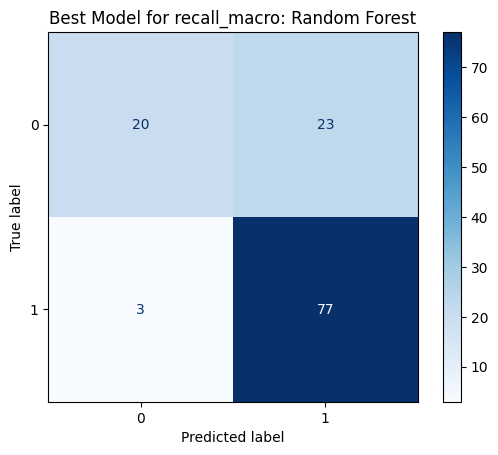

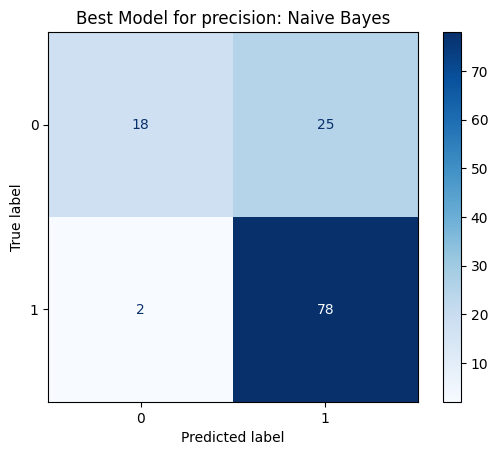

In [55]:
for score in scores:
  id_best = results.loc[results['scoring']==score, score].idxmax()
  clf_best = clfs[id_best]
  y_pred = clf_best.predict(X_test)
  cm = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_test, cmap='Blues')
  model = results.at[id_best,'model']
  cm.ax_.set_title(f'Best Model for {score}: {model}')